In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
from keras.models import load_model, Model
from PIL import Image

from utils import monta_lista_ids_e_imagens, view_imagens

MODELO = 'GPUNormal100Epoch'

In [7]:
import tensorflow as tf
tf.__version__

'1.8.0'

In [8]:
import sys
sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

In [9]:
_ids, imagens = monta_lista_ids_e_imagens('2017-07-01', '2017-07-05')

print(_ids[:4])
print(imagens[:4])


[ObjectId('5aaa55e12a87955816d5deaa'), ObjectId('5aaa55e12a87955816d5de1e'), ObjectId('5aaa55de2a87955816d5d79e'), ObjectId('5aaa55e22a87955816d5e028')]
[[<PIL.Image.Image image mode=RGB size=434x211 at 0x7FCCF4FAAF60>], [<PIL.Image.Image image mode=RGB size=438x227 at 0x7FCCF4FAEF28>], [<PIL.Image.Image image mode=RGB size=217x225 at 0x7FCCF4FAEEB8>], [<PIL.Image.Image image mode=RGB size=469x181 at 0x7FCCEFADD898>]]


In [16]:
SIZE = 128, 128
noise_factor = 0.4

def image_prepare(image):
    image = image.resize(SIZE, Image.ANTIALIAS)
    image_array = np.asarray(image).astype('float32')
    image_array = image_array[:, :, 0] / 255
    image_array = np.expand_dims([image_array], axis=3)
    """
    image_noisy = image_array + noise_factor * \
        np.random.normal(loc=0.5, scale=0.33, size=image_array.shape)
    image_noisy = np.clip(image_noisy, 0., 1.)
    """
    return image_array  # , image_noisy

In [17]:
len(imagens)

1296

In [23]:
images = [image_prepare(imagem[0]) for imagem in imagens]

In [24]:
images[0]


array([[[[0.99607843],
         [0.99607843],
         [0.99607843],
         ...,
         [0.99607843],
         [1.        ],
         [0.99215686]],

        [[0.99607843],
         [0.99607843],
         [0.99215686],
         ...,
         [0.99215686],
         [0.99607843],
         [0.9843137 ]],

        [[0.99607843],
         [0.99607843],
         [0.99215686],
         ...,
         [0.9843137 ],
         [0.9843137 ],
         [0.99607843]],

        ...,

        [[0.01960784],
         [0.14901961],
         [0.50980395],
         ...,
         [0.29411766],
         [0.13333334],
         [0.2901961 ]],

        [[0.01176471],
         [0.1254902 ],
         [0.4745098 ],
         ...,
         [0.20784314],
         [0.02745098],
         [0.16078432]],

        [[0.01176471],
         [0.15294118],
         [0.43529412],
         ...,
         [0.36862746],
         [0.13333334],
         [0.1764706 ]]]], dtype=float32)

In [25]:
autoencoder = load_model('autoencoder%s.h5' % MODELO)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
# encoder.save('encoder.h5')

In [28]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [26]:
code = encoder.predict(images[0])
print(code.shape)
print(code.reshape(128))

(1, 4, 4, 8)
[0.         1.5356889  0.         0.6908609  0.2948014  0.
 0.         0.676373   0.         1.06987    0.         0.36836132
 0.12524961 0.         0.         0.20758998 0.         1.017396
 0.         0.40369102 0.16732405 0.         0.         0.35548964
 0.         1.268794   0.08612146 0.19190298 0.6253757  0.
 0.09339918 0.09776555 0.15395567 1.369697   0.         0.8117393
 0.60948795 0.         0.         0.7532394  0.         1.2155236
 0.047358   0.7126886  0.28146422 0.         0.         0.17492303
 0.         1.1927259  0.05556095 1.2019224  0.26201957 0.
 0.         0.74271166 0.         1.5167334  0.1230102  0.269414
 0.5697819  0.         0.03460969 0.         0.29891425 0.26708078
 0.1939325  0.28141674 0.52453697 0.         0.         0.77118456
 0.5211555  0.32683533 0.26930746 0.2798695  0.34528983 0.
 0.         0.03179266 0.31203303 0.59356296 0.12561703 0.9359257
 0.         0.         0.         0.76463115 0.         1.7800895
 0.40772775 0.71456796

In [10]:
# Testes de desempenho
import time
s0 = time.time()
for r in range(1000):
    encoder.predict(np.expand_dims(images[:1], axis=3)).reshape(128)
s1 = time.time()
elapsed = s1 - s0
print('Tempo 1 imagem 1000 reps em segundos: {0:.4f}.'.format(elapsed) + \
      ' {0:.4f} por imagem.'.format(elapsed / 1000))

s0 = time.time()
encoder.predict(np.expand_dims(images[:1000], axis=3)).reshape(1000, 128)
s1 = time.time()
elapsed = s1 - s0
print('Tempo 1000 imagens em segundos: {0:.2f}.'.format(elapsed) + \
      ' {0:.4f} por imagem.'.format(elapsed / 1000))


Tempo 1 imagem 1000 reps em segundos: 4.2462. 0.0042 por imagem.
Tempo 1000 imagens em segundos: 3.08. 0.0031 por imagem.


<Figure size 432x288 with 0 Axes>

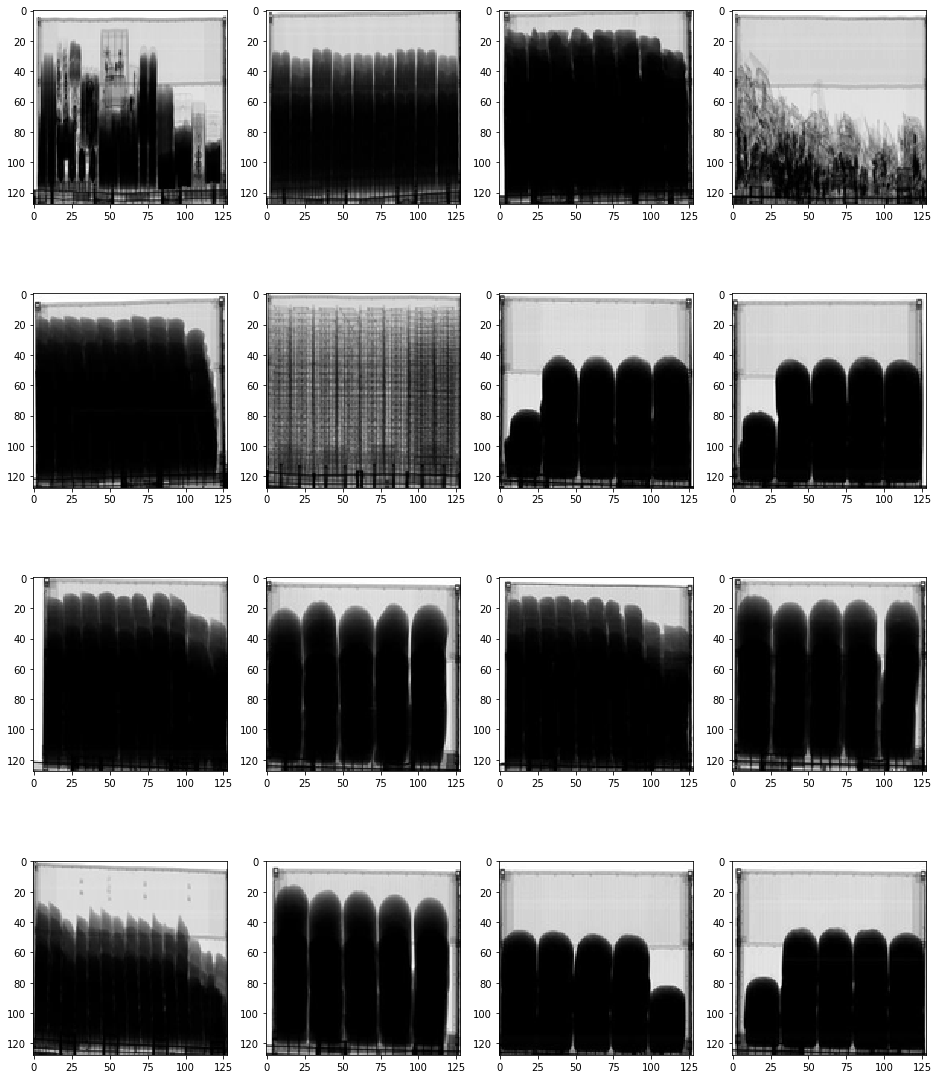

In [11]:
view_imagens(images)